# Imports y utilidades

In [1]:
import enum
import gc
import pathlib as pl
from datetime import datetime

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

tqdm.pandas()


class Channel(str, enum.Enum):
    F3 = "F3"
    F4 = "F4"
    C3 = "C3"
    C4 = "C4"
    P3 = "P3"
    P4 = "P4"

In [2]:
def human_readable_size(size, decimal_places=2):
    for unit in ["B", "KiB", "MiB", "GiB", "TiB", "PiB"]:
        if size < 1024.0 or unit == "PiB":
            break
        size /= 1024.0
    return f"{size:.{decimal_places}f} {unit}"

# Leer datos
Primero el csv, pero para que sea más rápido luego, lo paso a parquet.

In [3]:
%%time

data_dir = pl.Path("habla-imaginada-clasificacion-senales-EEG")

if not (parquet_dir := data_dir / "X_train" / "X_train.parquet").exists():
    pd.read_csv(data_dir / "X_train" / "X_train").to_parquet(parquet_dir, index=False)

x_train = pd.read_parquet(parquet_dir)

CPU times: user 3.97 s, sys: 6.37 s, total: 10.3 s
Wall time: 3.06 s


In [4]:
y_train = pd.read_csv(
    "habla-imaginada-clasificacion-senales-EEG/y_train.csv", names=["vocal"]
)

# Breve EDA

In [5]:
print("El dataset de train tiene {} filas y {} columnas".format(*x_train.shape))

El dataset de train tiene 4272 filas y 24577 columnas


Reviso la cantidad de columnas por canal/prefijo.

In [6]:
pd.Series([x.split("_")[0] for x in x_train.columns]).value_counts()

F3        4096
F4        4096
C3        4096
C4        4096
P3        4096
P4        4096
sujeto       1
Name: count, dtype: int64

In [7]:
human_readable_size(x_train.memory_usage(deep=True, index=False).sum())

'801.24 MiB'

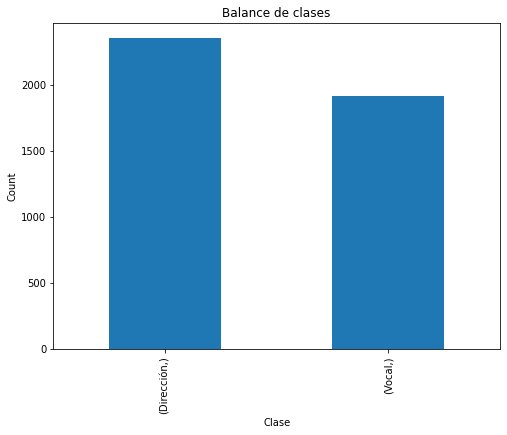

In [8]:
y_train.replace({True: "Vocal", False: "Dirección"}).value_counts().plot(
    kind="bar",
    title="Balance de clases",
    figsize=(8, 6),
    ylabel="Count",
    xlabel="Clase",
)
plt.show()

No están terriblemente desbalanceadas, así que no va a ser una prioridad trabajar sobre eso.

Veamos un ejemplo de EEG

In [9]:
sample_eeg = x_train.sample(1).drop(columns=["sujeto"]).melt()
sample_eeg = sample_eeg.join(
    sample_eeg.variable.str.extract(r"(?P<channel>[FCP]\d)_(?P<step>\d+)")
).drop(columns=["variable"])
sample_eeg.step = sample_eeg.step.astype(int)
sample_eeg = sample_eeg.pivot(
    index="step", columns=["channel"], values=["value"]
).sort_index()
sample_eeg = sample_eeg[sorted(sample_eeg.columns)].droplevel(0, axis=1)

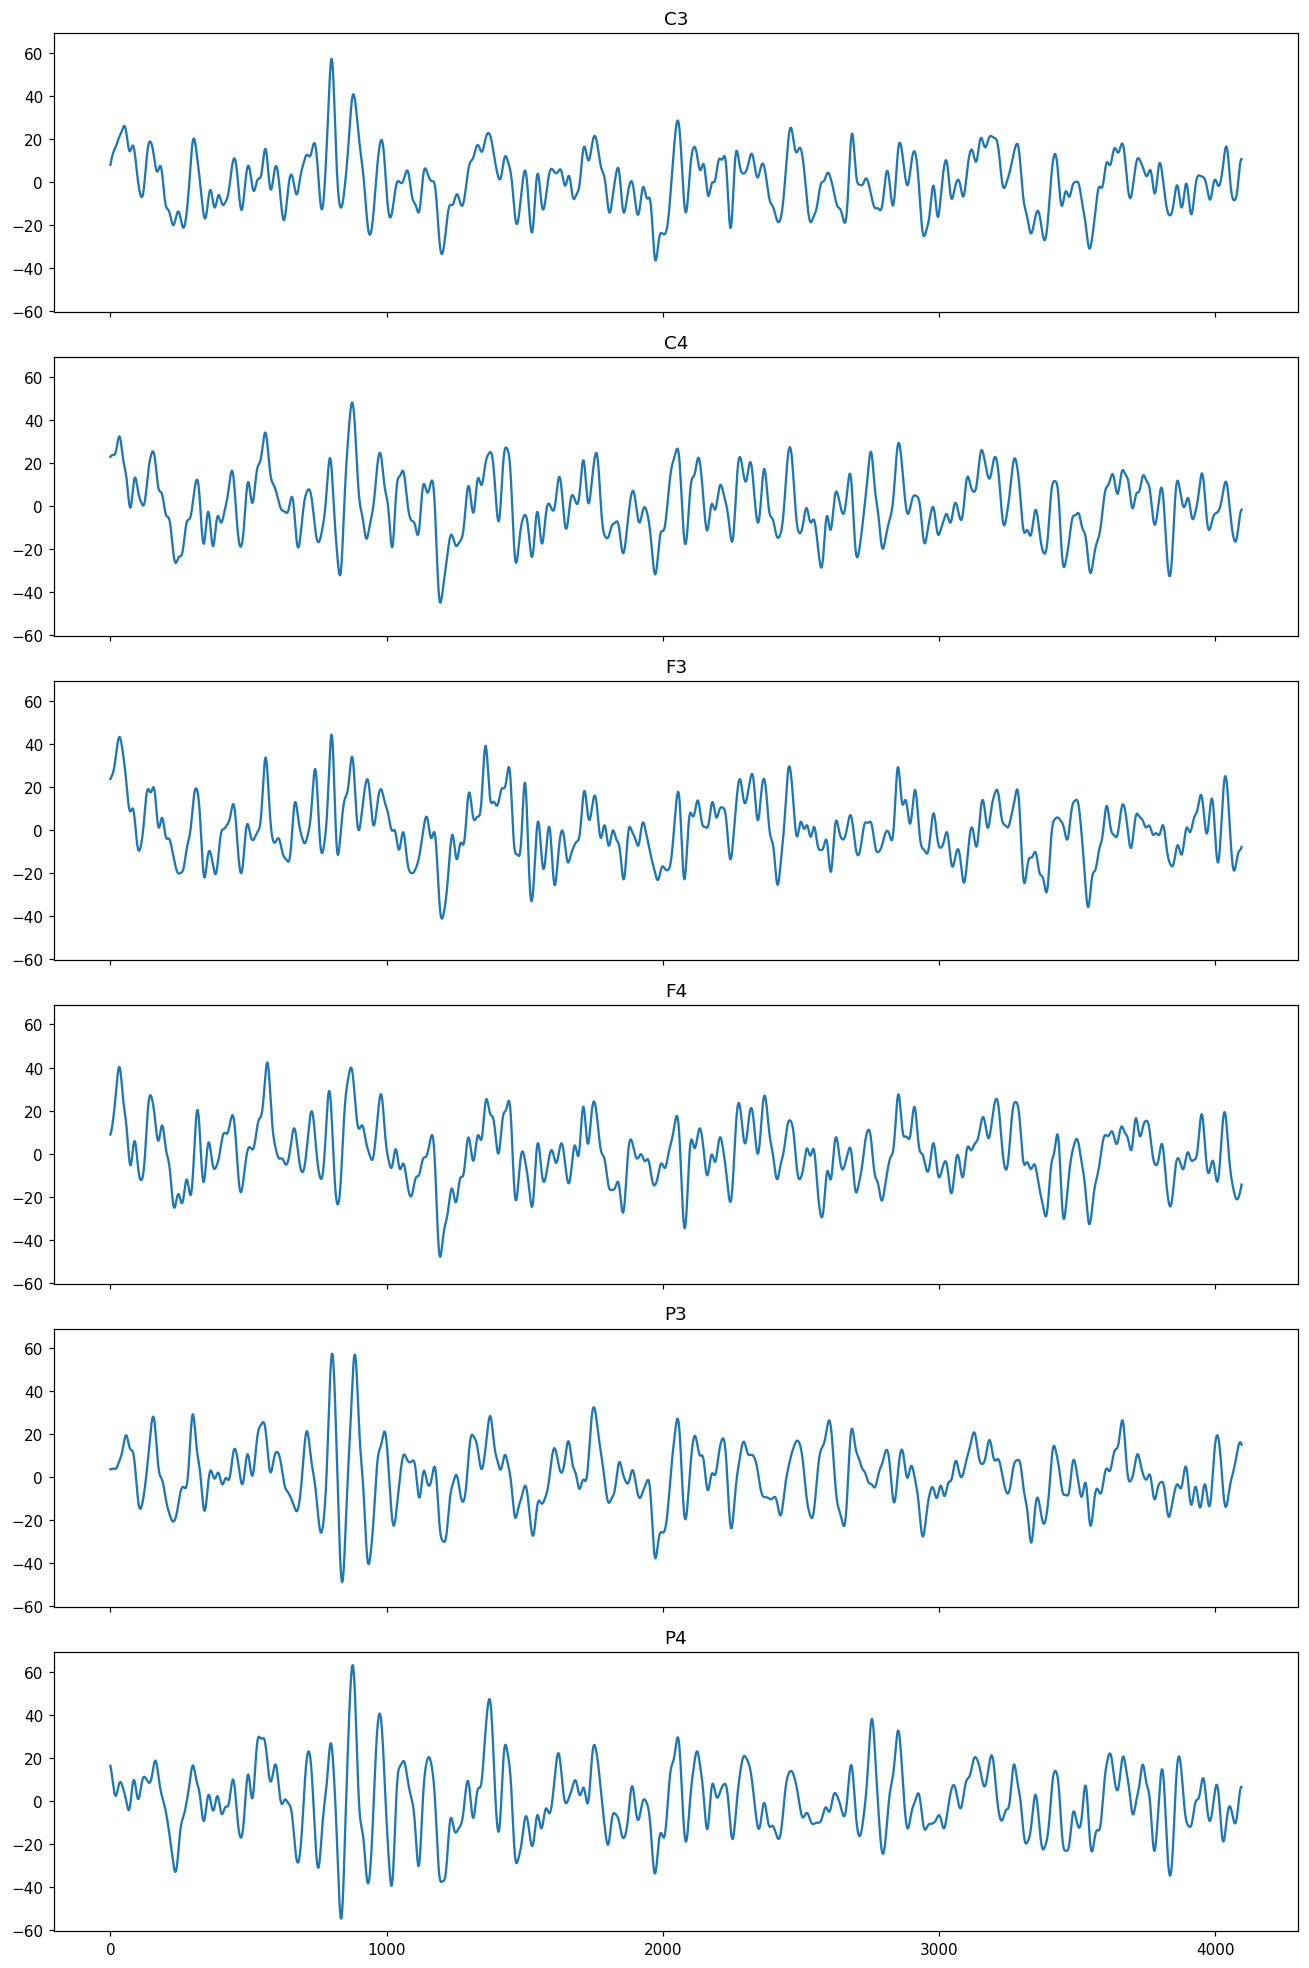

In [10]:
f, axes = plt.subplots(
    nrows=6, ncols=1, figsize=(12, 18), dpi=110, sharey=True, sharex=True
)
for ax, col in zip(axes, sample_eeg.columns):
    ax.plot(sample_eeg[col])
    ax.set_title(col)
plt.tight_layout()
plt.show()

No sé que esperaba ver... así que sigamos.

# Data wrangling

El dataset está en wide format, pero para manipularlo sería mucho más cómodo tenerlo en long format.  
Por ejemplo, me gustaría tener el promedio móvil de cada canal. Hacer eso en wider format es... incómodo.

In [11]:
x_train.sujeto = x_train.sujeto.astype("category")

x_train = x_train.reset_index().rename(columns={"index": "obs"})

x_train = x_train.melt(id_vars=["obs", "sujeto"])

x_train.variable = x_train.variable.astype("category")
x_train.obs = x_train.obs.astype("category")
x_train.value = x_train.value.astype("float16")

x_train = x_train.drop(columns=["sujeto"])

x_train["channel"] = x_train.variable.progress_apply(
    lambda x: Channel(x.split("_")[0])
).astype("category")
x_train["step"] = x_train.variable.progress_apply(
    lambda x: np.uint16(x.split("_")[1])
).astype("uint16")

x_train.drop(columns=["variable"], inplace=True)

x_train = x_train.sort_values(["obs", "step", "channel"])

gc.collect()

"""
rolling_mean = x_train.groupby(["obs", "channel"]).value.rolling(window=100, min_periods=10).mean()

rolling_mean = rolling_mean.droplevel(level=[0,1])

rolling_mean = rolling_mean.rename("rolling_mean")

print("1")
x_train = pd.merge(x_train, rolling_mean, right_index=True, left_index=True)
del rolling_mean
gc.collect()
"""

"""
rolling_diff = x_train.groupby(["obs", "channel"]).value.diff().rename("rolling_diff")

print("2")
x_train = x_train.join(rolling_diff)
del rolling_diff
gc.collect()
"""

"""
rolling_pct_diff = x_train.groupby(["obs", "channel"]).value.pct_change().rename("rolling_pct_diff")

print("3")
x_train = x_train.join(rolling_pct_diff)
del rolling_pct_diff
gc.collect()
"""

statistics = (
    x_train.groupby(["obs", "channel"])
    .value.agg([np.mean, np.std, np.min, np.max, np.median])
    .astype(np.float32)
)

x_train = x_train.pivot(
    index="obs",
    columns=["channel", "step"],
    values=["value"],  # , "rolling_mean", "rolling_diff", "rolling_pct_diff"]
)

statistics = statistics.reset_index().pivot(
    index="obs", columns=["channel"], values=["mean", "std", "amin", "amax", "median"]
)

x_train.columns = x_train.columns.map(lambda x: "_".join(map(str, x)))
statistics.columns = statistics.columns.map(lambda x: "_".join(map(str, x)))

x_train = pd.merge(x_train, statistics, left_index=True, right_index=True)

x_train.head()

  0%|          | 0/104988672 [00:00<?, ?it/s]

  0%|          | 0/104988672 [00:00<?, ?it/s]

,value_Channel.C3_0,value_Channel.C4_0,value_Channel.F3_0,value_Channel.F4_0,value_Channel.P3_0,value_Channel.P4_0,value_Channel.C3_1,value_Channel.C4_1,value_Channel.F3_1,value_Channel.F4_1,...,amax_Channel.F3,amax_Channel.F4,amax_Channel.P3,amax_Channel.P4,median_Channel.C3,median_Channel.C4,median_Channel.F3,median_Channel.F4,median_Channel.P3,median_Channel.P4
obs,,,,,,,,,,,,,,,,,,,,,
0,0.121643,11.726562,15.218750,13.789062,-0.495605,1.291992,-0.214111,11.437500,14.671875,12.937500,...,48.78125,46.59375,28.265625,39.12500,0.151855,-0.316895,0.821533,-0.129822,-0.446289,-0.718506
1,11.375000,-9.625000,1.153320,-10.960938,20.218750,4.250000,12.539062,-8.812500,1.745117,-12.554688,...,56.31250,71.37500,45.406250,64.25000,0.611816,-0.820557,-0.380005,-1.148438,0.224060,0.164062
2,-9.742188,-25.984375,-15.664062,-24.656250,-4.898438,-15.554688,-9.812500,-25.140625,-15.625000,-24.062500,...,49.56250,61.43750,46.031250,57.87500,-1.221191,-2.190430,-0.643311,-2.405273,-1.028809,-1.100586
3,-2.478516,-5.753906,-3.261719,-19.171875,-0.064636,-2.044922,-1.968750,-5.085938,-3.408203,-19.140625,...,56.12500,46.90625,38.875000,52.34375,0.009102,-0.257080,0.296021,0.565918,-0.212402,-0.458252
4,2.001953,-19.359375,-7.308594,-16.390625,-2.117188,-10.554688,3.109375,-18.359375,-6.632812,-15.945312,...,65.06250,66.81250,42.218750,47.84375,0.318970,-0.679443,-0.170715,-0.858887,-0.185181,-1.525391


Comenté varias transformaciones que vi que empeoraban el resultado. Normalizar cada canal por observación me dió peores resultados también.

# Entrenamiento
Esta es quizás la sección más vaga de todo este notebook. Sería interesante probar otros modelos (redes neuronales, modelos de time series, quizás?), pero voy a tratarlo como un problema meramente tabular.

In [12]:
import lightgbm as lgbm
from sklearn.metrics import accuracy_score

Simplemento hago KFold Cross Validation con los parámetros que vea que puedan ser útiles.  
Demasiados estimadores harán más lento el entrenamiento con ganancias cada vez más marginales, asi que lo dejo en 100 y listo.

In [13]:
y_train = y_train.values.ravel()

In [14]:
from sklearn.model_selection import GridSearchCV

clf = lgbm.LGBMClassifier()

gs = GridSearchCV(
    clf, {"n_estimators": [100], "num_leaves": [31], "n_jobs": [16]}, cv=5, refit=True
)

In [15]:
gs.fit(x_train, y_train)

[LightGBM] [Info] Number of positive: 1535, number of negative: 1882
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 2.012541 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6274530
[LightGBM] [Info] Number of data points in the train set: 3417, number of used features: 24606
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.449224 -> initscore=-0.203805
[LightGBM] [Info] Start training from score -0.203805
[LightGBM] [Info] Number of positive: 1535, number of negative: 1882
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 2.056905 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6274530
[LightGBM] [Info] Number of data points in the train set: 3417, number of used features: 24606
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.449224 -> initscore=-0.203805
[LightGBM] [Info] Start training from score -0.203805
[Light

GridSearchCV(cv=5, estimator=LGBMClassifier(),
             param_grid={'n_estimators': [100], 'n_jobs': [16],
                         'num_leaves': [31]})

In [16]:
gs.best_score_

0.7111398715367654

In [17]:
gs.best_params_

{'n_estimators': 100, 'n_jobs': 16, 'num_leaves': 31}

Deberíamos tener altísimo overfitting:

In [18]:
preds = gs.predict(x_train)
accuracy_score(y_train, preds)

1.0

Con los shap values podemos entender rápidamente qué features son más importantes para el modelo.

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


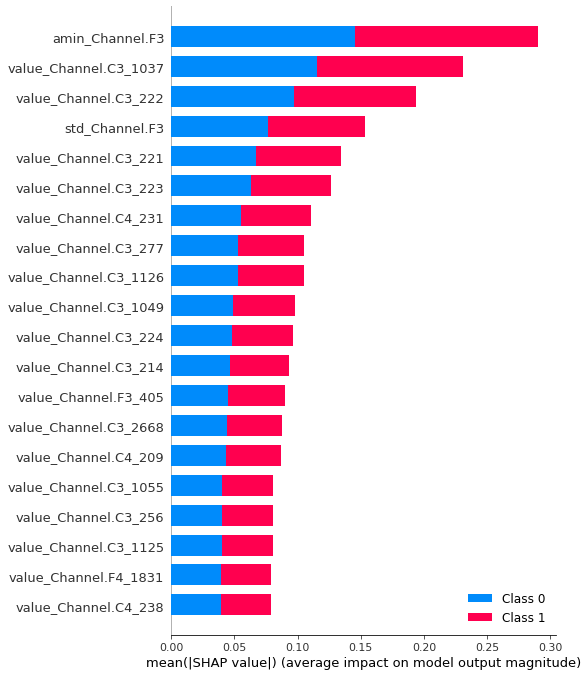

In [19]:
import shap

# print the JS visualization code to the notebook
shap.initjs()

explainer = shap.TreeExplainer(gs.best_estimator_)
shap_values = explainer.shap_values(x_train)

shap.summary_plot(shap_values, x_train)

# Predecir

In [20]:
# del x_train
# del y_train

In [21]:
x_test = pd.read_csv(data_dir / "X_test" / "X_test")
x_test.head()

,F3_0,F3_1,F3_2,F3_3,F3_4,F3_5,F3_6,F3_7,F3_8,F3_9,...,P4_4087,P4_4088,P4_4089,P4_4090,P4_4091,P4_4092,P4_4093,P4_4094,P4_4095,sujeto
0,-2.009904,-1.031905,-0.070962,0.863916,1.764523,2.623325,3.433236,4.187431,4.879149,5.501530,...,7.165156,7.201484,7.240581,7.301281,7.400873,7.554270,7.773300,8.066092,8.436606,A
1,-5.457456,-4.282562,-3.067805,-1.830383,-0.587779,0.643013,1.846224,3.007957,4.116735,5.163947,...,-11.859823,-12.189498,-12.377241,-12.427344,-12.348589,-12.153594,-11.858051,-11.479873,-11.038301,A
2,1.626769,0.902607,0.164088,-0.579422,-1.318754,-2.045237,-2.750973,-3.429142,-4.074287,-4.682561,...,42.857304,42.944770,42.869305,42.627342,42.216880,41.637524,40.890420,39.978138,38.904600,A
3,-15.776263,-15.153750,-14.405528,-13.535155,-12.552266,-11.472412,-10.316658,-9.110797,-7.884379,-6.669542,...,-10.572659,-9.211359,-7.807257,-6.379692,-4.948716,-3.534313,-2.155746,-0.830949,0.423976,A
4,-10.542398,-10.561781,-10.483931,-10.304099,-10.020597,-9.635073,-9.152575,-8.581372,-7.932704,-7.220280,...,5.878397,4.707628,3.500991,2.276504,1.052793,-0.151440,-1.317915,-2.429351,-3.469868,A


In [22]:
x_test.sujeto = x_test.sujeto.astype("category")

x_test = x_test.reset_index().rename(columns={"index": "obs"})

x_test = x_test.melt(id_vars=["obs", "sujeto"])

x_test.variable = x_test.variable.astype("category")
x_test.obs = x_test.obs.astype("category")
x_test.value = x_test.value.astype("float16")

x_test = x_test.drop(columns=["sujeto"])

x_test["channel"] = x_test.variable.progress_apply(
    lambda x: Channel(x.split("_")[0])
).astype("category")
x_test["step"] = x_test.variable.progress_apply(
    lambda x: np.uint16(x.split("_")[1])
).astype("uint16")

x_test.drop(columns=["variable"], inplace=True)

x_test = x_test.sort_values(["obs", "step", "channel"])

gc.collect()
"""
rolling_mean = x_test.groupby(["obs", "channel"]).value.rolling(window=100, min_periods=10).mean()

rolling_mean = rolling_mean.droplevel(level=[0,1])

rolling_mean = rolling_mean.rename("rolling_mean")

print("1")
x_test = pd.merge(x_test, rolling_mean, right_index=True, left_index=True)
del rolling_mean
gc.collect()
"""
"""
rolling_diff = x_test.groupby(["obs", "channel"]).value.diff().rename("rolling_diff")

print("2")
x_test = x_test.join(rolling_diff)
del rolling_diff
gc.collect()
"""
"""
rolling_pct_diff = x_test.groupby(["obs", "channel"]).value.pct_change().rename("rolling_pct_diff")

print("3")
x_test = x_test.join(rolling_pct_diff)
del rolling_pct_diff
gc.collect()
"""

statistics = (
    x_test.groupby(["obs", "channel"])
    .value.agg([np.mean, np.std, np.min, np.max, np.median])
    .astype(np.float32)
)

x_test = x_test.pivot(
    index="obs",
    columns=["channel", "step"],
    values=["value"],  # , "rolling_mean", "rolling_diff", "rolling_pct_diff"]
)

statistics = statistics.reset_index().pivot(
    index="obs", columns=["channel"], values=["mean", "std", "amin", "amax", "median"]
)

x_test.columns = x_test.columns.map(lambda x: "_".join(map(str, x)))
statistics.columns = statistics.columns.map(lambda x: "_".join(map(str, x)))

x_test = pd.merge(x_test, statistics, left_index=True, right_index=True)

  0%|          | 0/75423744 [00:00<?, ?it/s]

  0%|          | 0/75423744 [00:00<?, ?it/s]

In [23]:
preds = gs.predict(x_test)

In [24]:
df_pred = (
    pd.DataFrame(preds, columns=["is_letter"])
    .reset_index()
    .rename(columns={"index": "ID"})
)
df_pred.ID += 1
df_pred.to_csv(f"pred_{datetime.now():%Y-%m-%d %H-%M-%S}.csv", index=False)